# Calling BERT model from JAX (with BERT weights in JAX)

In [1]:
from __future__ import annotations

import sys
from pathlib import Path
import random
import time

from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
import torch
from torch import Tensor
from torch.func import functional_call
import jax
from jax import numpy as jnp, Array
import matplotlib.pyplot as plt
import numpy as np

from torch2jax import tree_t2j, torch2jax_with_vjp


### Loading the dataset and the model (in PyTorch)

In [2]:
dataset = load_dataset("wikitext", "wikitext-2-v1", split="train")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.to(device)
model.eval()


def tokenizer_torch(text: list[str]) -> dict[str, Tensor]:
    encoded = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    return {k: v.to(device) for (k, v) in encoded.items()}

Found cached dataset wikitext (/home/rdyro/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Let's convert the torch model to a function, using `torch.func.functional_call`

In [3]:
params, buffers = dict(model.named_parameters()), dict(model.named_buffers())

def torch_fwd_fn(params, buffers, input):
    return functional_call(model, (params, buffers), args=(), kwargs=input).pooler_output

In [4]:
nb = 16
text = [x["text"] for x in random.choices(dataset, k=int(1e3)) if len(x["text"]) > 100][:nb]
encoded_text = tokenizer_torch(text)

### We do not need to specify output, the library will call the torch function ones to infer the output

In [5]:
jax_fwd_fn = jax.jit(torch2jax_with_vjp(torch_fwd_fn, params, buffers, encoded_text))
params_jax, buffers_jax = tree_t2j(params), tree_t2j(buffers)
encoded_text_jax = tree_t2j(encoded_text)

### Taking gradients wrt model parameters

In [6]:
g_fn = jax.jit(jax.grad(lambda params: jnp.sum(jax_fwd_fn(params, buffers_jax, encoded_text_jax))))
g_torch_fn = torch.func.grad(lambda params: torch.sum(torch_fwd_fn(params, buffers, encoded_text)))

In [7]:
gs = g_fn(params_jax)
gs_torch = tree_t2j(g_torch_fn(params))

In [8]:
total_err = 0
for k in gs.keys():
    err = jnp.linalg.norm(gs[k] - gs_torch[k])
    total_err += err
print(f"Total error in gradient: {total_err:.4e}")

Total error in gradient: 0.0000e+00


### Timing the gains over `pure_callback`

In [9]:
root_path = Path("").absolute().parent / "tests"
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))

from pure_callback_alternative import wrap_torch_fn

In [10]:
with torch.no_grad():
    output_shapes = model(**encoded_text).pooler_output
jax_fwd_fn2 = jax.jit(wrap_torch_fn(torch_fwd_fn, output_shapes, device=device.type))

In [11]:
t1s, t2s, t3s = [], [], []
for i in tqdm(range(100)):
    text = [x["text"] for x in random.choices(dataset, k=int(1e3)) if len(x["text"]) > 100][:nb]
    encoded_text = tokenizer_torch(text)
    encoded_text_jax = tree_t2j(encoded_text)

    t = time.time()
    out1 = jax_fwd_fn(params_jax, buffers_jax, encoded_text_jax)
    out1.block_until_ready()
    t = time.time() - t
    t1s.append(t)
    #print(f"JAX version took:   {t:.4e} s")

    t = time.time()
    out2 = jax_fwd_fn2(params_jax, buffers_jax, encoded_text_jax)[0]
    out2.block_until_ready()
    t = time.time() - t
    t2s.append(t)
    #print(f"JAX version2 took:  {t:.4e} s")

    t = time.time()
    with torch.no_grad():
        out3 = model(**encoded_text).pooler_output
    torch.cuda.synchronize()
    t = time.time() - t
    t3s.append(t)
    #print(f"Torch version took: {t:.4e} s")
    #print(f"err = {jnp.linalg.norm(out1 - tree_t2j(out3)):.4e}")
    #print(f"err = {jnp.linalg.norm(out2 - tree_t2j(out3)):.4e}")


  0%|          | 0/100 [00:00<?, ?it/s]/home/rdyro/Dropbox/projects/torch2jax/tests/pure_callback_alternative.py:27: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  args = tree_map(lambda x: torch.as_tensor(x, device=device), args)
100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


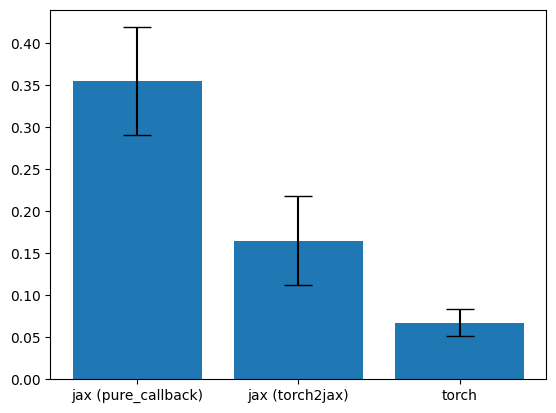

In [12]:
plt.figure()
plt.bar(
    ["jax (pure_callback)", "jax (torch2jax)", "torch"],
    [np.mean(t2s), np.mean(t1s), np.mean(t3s)],
    yerr=[np.std(t2s), np.std(t1s), np.std(t3s)],
    capsize=10.0,
)
plt.show()
